In [17]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

plt.rcParams['text.usetex'] = True

In [31]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50

T_coupling = 0
w_h = 1
l = 5
n = 3

# the important parameters for this test
T_h = 10     # delay in Hes of first cell

num_tsteps = 20000
dt = 0.2

In [32]:
#uncoupled periods: 
w_coupling = 0 

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)


In [33]:
h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type='Delta', initial_type='uniform')

100%|██████████| 19999/19999 [00:05<00:00, 3778.52it/s]


In [9]:
hes_delays = np.linspace(0, 10, 11) + 15

results_uncoupled = np.zeros((len(hes_delays), num_tsteps, 2))

for i in range(len(hes_delays)):
    T_h = hes_delays[i]  # set the delay in Hes of first cell
    params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)
    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
    results_uncoupled[i,:,0] = h[:,0].flatten()
    results_uncoupled[i,:,1] = d[:,0].flatten()


100%|██████████| 19999/19999 [00:05<00:00, 3908.18it/s]


In [18]:
def estimate_period_from_peaks(signal, time=None, height=None, distance=500, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, ignores the first peak if it's a large outlier

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)

    if len(peaks) < 2:
        return None, np.array([])  # Not enough peaks to estimate period

    # Optionally remove initial outlier peak
    peak_vals = signal[peaks]

    # Assume uniform spacing if time is not given
    if time is None:
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 2:
        return None, peak_times  # Still not enough peaks

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

In [19]:
def get_distinguishable_ylgn_colors(k, min_val=0.3, max_val=0.8):
    """
    Returns k distinguishable colors from the 'YlGn' colormap,
    avoiding very light (near white) colors for better contrast on white backgrounds.

    Parameters:
    - k: Number of colors.
    - min_val: Minimum position in the colormap (0 = lightest, 1 = darkest).
    - max_val: Maximum position in the colormap.
    """
    assert 0 <= min_val < max_val <= 1, "min_val and max_val must be in (0, 1]"
    cmap = cm.get_cmap('YlGn')
    values = np.linspace(min_val, max_val, k)
    colors = [cmap(v) for v in values]
    return colors

Periods for uncoupled oscillations: [109.95428571 112.02285714 114.35294118 117.31515152 121.51875
 126.18064516 130.88       135.53103448 140.09285714 144.56296296
 148.92307692]


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_11172\985238926.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


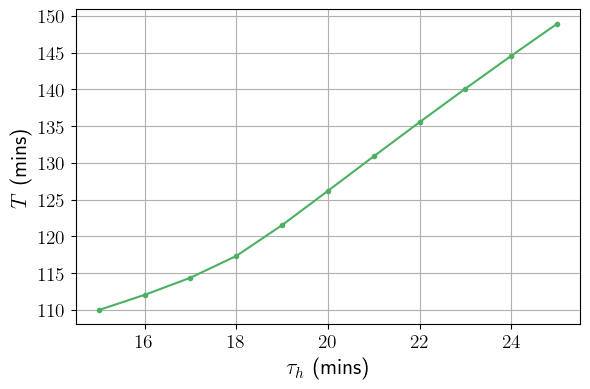

In [ ]:
periods_uncoupled = np.zeros(len(hes_delays))

for i in range(len(hes_delays)):
    # Estimate period for each delay
    periods_uncoupled[i], _ = estimate_period_from_peaks(results_uncoupled[i, :, 0], time=np.arange(num_tsteps) * dt, distance=500)

print("Periods for uncoupled oscillations:", periods_uncoupled)

cmap = cm.get_cmap('YlGn')
colour = cmap(0.6)

plt.figure(figsize=(6, 4))

plt.plot(hes_delays, periods_uncoupled, marker='.', linestyle='-', color=colour)
plt.xlabel(r'$\tau_h$ (mins)', fontsize=16)
plt.ylabel(r'$T$ (mins)', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig('single_cell_hes_periods.png', dpi=600)

In [44]:
hes_examples = [10, 20]

results_examples= np.zeros((len(hes_delays), num_tsteps, 2))

for i in range(len(hes_examples)):
    T_h = hes_examples[i]  # set the delay in Hes of first cell
    params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)
    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
    results_uncoupled[i,:,0] = h[:,0].flatten()
    results_uncoupled[i,:,1] = m_h[:,0].flatten()

100%|██████████| 19999/19999 [00:02<00:00, 7084.98it/s]


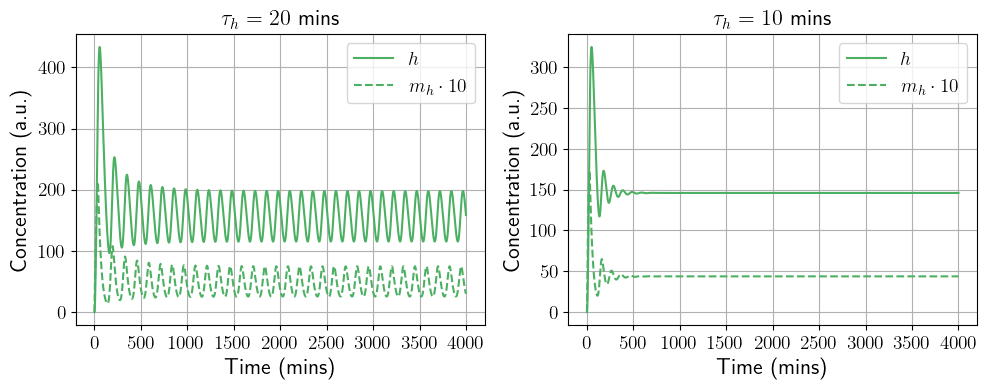

In [50]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(np.arange(0, num_tsteps * dt, dt), results_uncoupled[1, :, 0], color=colour, label=r'$h$')
plt.plot(np.arange(0, num_tsteps * dt, dt), results_uncoupled[1, :, 1]*10, color=colour, linestyle='--', label=r'$m_h \cdot 10$')
plt.xlabel(r'Time (mins)', fontsize=16)
plt.ylabel(r'Concentration (a.u.)', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'$\tau_h = 20$ mins', fontsize=16)
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.plot(np.arange(0, num_tsteps * dt, dt), results_uncoupled[0, :, 0], color=colour, label=r'$h$')
plt.plot(np.arange(0, num_tsteps * dt, dt), results_uncoupled[0, :, 1]*10, color=colour, linestyle='--', label=r'$m_h\cdot 10$')
plt.xlabel(r'Time (mins)', fontsize=16)
plt.ylabel(r'Concentration (a.u.)', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'$\tau_h = 10$ mins', fontsize=16)
plt.tight_layout()
plt.legend(fontsize=14)

plt.savefig('single_cell_examples.png', dpi=600)